In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
import seaborn as sns
plt.style.use('ggplot')
# 声明使用 Seaborn 样式
sns.set()
# 有五种seaborn的绘图风格，它们分别是：darkgrid, whitegrid, dark, white, ticks。默认的主题是darkgrid。
sns.set_style("whitegrid")
# 有四个预置的环境，按大小从小到大排列分别为：paper, notebook, talk, poster。其中，notebook是默认的。
sns.set_context('notebook')
# 中文字体设置-黑体
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False

# 盯市操作
当天市价出来后，调整手头风险资产的价值

In [173]:
def watch(V,P):
    '''
    V=（V0，V1,V2）:昨日资产价值
    P=（P1,P2）：今日gold，bitcoin涨跌幅
    '''
    price1,price2=P
    V[1]=V[1]*(1+price1)
    V[2]=V[2]*(1+price2)
    return V

# 动态仓位管理 太繁琐了，没有用，不要看这个

In [ ]:
def Variance(omega1,omega2,Dmax,Dmin):
    '''
    omega1=(var1g,var1b,cov1):往后一期的gold方差，bitcoin方差，协方差
    omega2=(var2g,var2b,cov2):往前一期的gold方差，bitcoin方差，协方差
    Dmax：历史的最大方差
    Dmin：历史的最小方差
    '''
    var1g,var1b,cov1=omega1
    var2g,var2b,cov2=omega2
    D1=(V1**2*var1g+V2**2*var1b+2*V1*V2*cov1)/V**2
    D2=(V1**2*var2g+V2**2*var2b+2*V1*V2*cov2)/V**2
    
    volatile=(D1-D2)/(Dmax-Dmin)
    return volatile

In [81]:
def position(V,f0,sign,volatile):
    '''
    V=V1+V2+Cash
    volatile=(D1-D2)/(Dmax-Dmin)
    sign:上扬趋势，1；下跌趋势，-1
     '''
    f=f0*(1+sign*volatile)
    M=f*V
    return f,M

# 非线性规划

In [160]:
(random.random()-0.5)*2

0.15916735496113255

In [18]:
def obj(w):
    w1=w
    w2=1-w
    mu=(w1*r1+w2*r2)/M
    var=(w1**2*var1+w2**2*var2+2*w1*w2*cov)
    return -mu/np.sqrt(var)#加负号，表示求最大值

In [17]:
# def obj(w):
#     w1,w2=w
#     mu=(w1*r1+w2*r2)/M
#     var=(w1**2*var1+w2**2*var2+2*w1*w2*cov)
#     return -mu/np.sqrt(var)#加负号，表示求最大值



## 双标的
黄金市场没有闭市，有gold和bitcoin两个标的

### optimize()写的有问题，不要看这个

In [75]:
import random
from scipy.optimize import minimize
def optimize(M,V,omega,r,cost=(0.01,0.02)):#omega=(var1,var2,cov)
    '''
     M:可供交易的金额
    
    V=(V0,V1,V2)
    V0:手头cash
    V1:手头gold价值
    V2：手头bitcoin价值
    
    omega=(var1,var2,cov)
    var1：gold方差
    var2：bitcoin方差
    cov：二者协方差
    
    r=(r1,r2)
    r1,r2:二者预期回报率
    
    cost：佣金费率，默认为0.01,0.02
    '''
    V0,V1,V2=V
    r1,r2=r    
    var1,var2,cov=omega
   
    x1=0
    x2=0
    x3=0
    
    def obj(w):
        w1=w
        w2=1-w
        mu0=w1*r1+w2*r2#无佣金条件下的预期收益率
        mu=mu0-abs(w1)*cost[0]-abs(w2)*cost[1]#有佣金条件下的预期收益率
        var=(w1**2*var1+w2**2*var2+2*w1*w2*cov)
        
        return -mu/np.sqrt(var)#加负号，表示求最大值
    
    def mv(w):
        w1=w
        w2=1-w
        mu0=(w1*r1+w2*r2)#无佣金条件下的预期收益率
        mu=mu0-abs(w1)*cost[0]-abs(w2)*cost[1]#有佣金条件下的预期收益率
        var=(w1**2*var1+w2**2*var2+2*w1*w2*cov)
        return mu0,mu,var
    
    cons=({'type':'ineq','fun':lambda w:w*M+V1},
          {'type':'ineq','fun': lambda w:V2+M-w*M})
    
    w0=(random.random()-0.5)*4#初始值为（-1,1）之间的随机数
    res = minimize(obj, w0,constraints=cons)  #第2个参数为初值
    mu0,mu,var= mv(res.x)
    
    if mu >0:#如果优化结果的收益率为正，则按照最优化结果投资
        W=np.append(res.x,1-res.x)
        
        commision= (abs(W[0])*cost[0] + abs(W[1])*cost[1] )*M#计算手续费


        X=[-(W[0]+W[1])*M-commision,  W[0]*M,  W[1]*M]#记的扣除手续费
        V=np.array(V)+np.array(X)
        print('Sharpe:',-res.fun)
        print('Mu0:',mv(res.x)[0])
        print('Mu:',mv(res.x)[1])    
        print('Var:',mv(res.x)[1])
        print(res.success)
        print('权重：',W)  #输出最优值、求解状态、最优解
        print('交易额：',X)
        print('commision:',commision)
        print('portfolio',V)
    else:#如果优化结果的收益率非正，则持有。
        W=np.zeros(2)
        commision=0
        X=[-(W[0]+W[1])*M-commision,  W[0]*M,  W[1]*M]#记的扣除手续费:依次为V0,V1,V2的变动额
        V=np.array(V)+np.array(X)
        print('持有')
        print('权重：',W)  #输出最优值、求解状态、最优解
        print('交易额：',X)
        # print('commision:',commision)
        print('portfolio',V)
    return W,X,V

In [51]:
optimize(200,(700,100,200),(0.001,0.002,0.0000015),(0.001,0.02))

持有
权重： [0. 0.]
交易额： [-0.0, 0.0, 0.0]
commision: 0
portfolio [700. 100. 200.]


(array([0., 0.]), [-0.0, 0.0, 0.0], array([700., 100., 200.]))

### dual pro这个是正解，看这个

In [2]:
import random
from scipy.optimize import minimize
def dual_pro(M,V,omega,r,cost=(0.01,0.02,0.1)):#omega=(var1,var2,cov)
    '''
     M:可供交易的金额
    
    V=(V0,V1,V2)
    V0:手头cash
    V1:手头gold价值
    V2：手头bitcoin价值
    
    omega=(var1,var2,cov)
    var1：gold方差
    var2：bitcoin方差
    cov：二者协方差
    
    r=(r1,r2)
    r1,r2:二者预期回报率
    
    cost：佣金费率和佣金费用占手头cash的上限，默认为0.01,0.02，0.1
    '''
    V0,V1,V2=V
    r1,r2=r    
    var1,var2,cov=omega
   
    x1=0
    x2=0
    x3=0
    
    def obj(w):
        w1,w2=w
        mu0=w1*r1+w2*r2#无佣金条件下的预期收益率
        mu=mu0-abs(w1)*cost[0]-abs(w2)*cost[1]#有佣金条件下的预期收益率
        var=(w1**2*var1+w2**2*var2+2*w1*w2*cov)
        
        return -mu/np.sqrt(var)#加负号，表示求最大值
    
    def mv(w):
        w1,w2=w
        mu0=(w1*r1+w2*r2)#无佣金条件下的预期收益率
        mu=mu0-abs(w1)*cost[0]-abs(w2)*cost[1]#有佣金条件下的预期收益率
        var=(w1**2*var1+w2**2*var2+2*w1*w2*cov)
        return mu0,mu,var
    
#     def con():
#         x1=W[0]*M-V1
#         x2=W[1]*M-V2
#         commision=(abs(x1)*cost[0] + abs(x2)*cost[1] )#根据风险资产的调整额计算手续费
        
    cons=({'type':'ineq','fun':lambda w:w[0]*M},#卖出限制
          {'type':'ineq','fun': lambda w:w[1]*M},#卖出限制
          {'type':'eq','fun': lambda w:1-w[0]-w[1]},#仓位限制
          {'type':'ineq','fun': lambda w:V0*cost[2]-abs(w[0]*M-V1)*cost[0]+abs(w[1]*M-V2)*cost[1]},)#手续费alpha限制

    # w0=[(random.random()-0.5)*4,(random.random()-0.5)*4]#初始值为（-2,2）之间的随机数
    w0=[0.5,0.5]
    
    res = minimize(obj, w0,constraints=cons)  #第2个参数为初值
    mu0,mu,var= mv(res.x)
    
    if mu >0:#如果优化结果的收益率为正，则按照最优化结果投资
        # W=np.append(res.x,1-res.x)
        W=res.x
        x1=W[0]*M-V1
        x2=W[1]*M-V2
        
        commision=(abs(x1)*cost[0] + abs(x2)*cost[1] )#根据风险资产的调整额计算手续费
        # commision= (abs(W[0])*cost[0] + abs(W[1])*cost[1] )*M#计算手续费#写错了
        x0=-x1-x2-commision
        
        X=np.array([x0,x1,x2])#资产向量调整额
        
        # print('Actual alpha:',commision/V0)

        # X=[-(W[0]+W[1])*M-commision,  W[0]*M,  W[1]*M]#记的扣除手续费
        V=np.array(V)+np.array(X)
        
        # print('Sharpe:',-res.fun)
        # print('Mu0:',mv(res.x)[0])
        # print('Mu:',mv(res.x)[1])    
        # print('Var:',mv(res.x)[1])
        # print(res.success)
        # print('权重：',W)  #输出最优值、求解状态、最优解
        # print('资产向量调整额：',X)
        # print('commision:',commision)
        # print('portfolio',V)
        # print('Actual f：',(V[1]+V[2])/V.sum())
    else:#如果优化结果的收益率非正，则持有。
        W=np.zeros(2)
        commision=0
        X=[-(W[0]+W[1])*M-commision,  W[0]*M,  W[1]*M]#记的扣除手续费:依次为V0,V1,V2的变动额
        V=np.array(V)+np.array(X)
        # print('持有')
        # print('权重：',W)  #输出最优值、求解状态、最优解
        # print('资产向量调整额：',X)
        # # print('commision:',commision)
        # print('portfolio',V)
    status=res.success
    return W,X,V,status

In [3]:
dual_pro(500,(1000,0,0),(0.001,0.002,0.0000015),(0.001,0.52))#还有问题，记得改
#改完了，没问题了，已经占领必然王国了

(array([-1.27675648e-14,  1.00000000e+00]),
 array([-5.10000000e+02, -6.38378239e-12,  5.00000000e+02]),
 array([ 4.90000000e+02, -6.38378239e-12,  5.00000000e+02]),
 True)

In [288]:
dual_pro(500,(700,100,200),(0.001,0.002,0.0000015),(0.001,0.52))#还有问题，记得改
#改完了，没问题了，已经占领必然王国了

Actual alpha: 0.010000000000000276
Sharpe: 11.180339887498945
Mu0: 0.5200000000000067
Mu: 0.5000000000000063
Var: 0.5000000000000063
True
权重： [-1.27675648e-14  1.00000000e+00]
资产向量调整额： [-207. -100.  300.]
commision: 7.000000000000193
portfolio [ 4.93000000e+02 -6.38067377e-12  5.00000000e+02]
Actual f： 0.503524672708963


(array([-1.27675648e-14,  1.00000000e+00]),
 array([-207., -100.,  300.]),
 array([ 4.93000000e+02, -6.38067377e-12,  5.00000000e+02]),
 True)

In [289]:
dual_pro(1055.747439*0.5,(509.1424543,0.001703365,546.6032815),(0.000293353,0.000391075,3.12437E-05),(-0.00419425,0.052108291))

Actual alpha: 0.0007357631725557546
Sharpe: 1.6236303592742805
Mu0: 0.052108291066037
Mu: 0.03210829103085013
Var: 0.03210829103085013
True
权重： [-1.17289556e-09  1.00000000e+00]
资产向量调整额： [ 1.83566571e+01 -1.70398414e-03 -1.87295614e+01]
commision: 0.37460826745859127
portfolio [ 5.27499111e+02 -6.19140741e-07  5.27873720e+02]
Actual f： 0.5001774766658243


(array([-1.17289556e-09,  1.00000000e+00]),
 array([ 1.83566571e+01, -1.70398414e-03, -1.87295614e+01]),
 array([ 5.27499111e+02, -6.19140741e-07,  5.27873720e+02]),
 True)

## 唯一标的One_target()看这个——需要画个流程图illustrate一下
黄金市场闭市，只有bitcoin一个标的

In [336]:
def One_target(M,V,omega,r,cost=(0.01,0.02)):
    '''
    M:可供交易的金额
    
    V=(V0,V1,V2)
    V0:手头cash
    V1:手头gold价值
    V2：手头bitcoin价值
    
    omega=(var1,var2,cov)
    var1：gold方差
    var2：bitcoin方差
    cov：二者协方差
    
    r=(r1,r2)
    r1,r2:二者预期回报率
    
    cost=(alpha1,alpha2,alpha)：佣金费率，默认为0.01,0.02，以及alpha
    '''
    V0,V1,V2=V
    r1,r2=r
    w1=0
    w2=0
    
    x1=0
    x2=0
    x3=0
    
    
    '''
    接下来是分类讨论，决策很简单，因为只有一个标的，所以就不存在最优资产组合的问题
    '''
    #这三种情况都是“持有”，不交易
    if abs(r2)<=cost[1]:
        w2=0
    elif M-V1-V2==0:
        w2=0
    elif r2*(M-V1-V2)<0:
        w2=0
    
    #这两种情况都是买入or卖出
    elif r2>0 and M>V1+V2:#买入bitcoin
        w2=1
        x2=M-V1-V2
        x3=-x2

    elif r2<0 and M<V1+V2:#卖出bitcoin
        w2=-1
        x2=w2*min([V1+V2-M,V2])#最多只能卖出手头上的bitcoin总价值
        x3=-x2
    # print('cost:',cost)
    # print('r',r)
    # print('V:',V)
    # print('M:',M)
    mu0=w2*r2#无佣金条件下的预计收益率
    mu=w2*r2-abs(w2)*cost[1]#存在佣金条件下的预计收益率
    
    W=np.array([w1,w2])
    commision= (abs(x1)*cost[0] + abs(x2)*cost[1] )#计算手续费
    x0=-x1-x2-commision
    
    X=np.array([x0,x1,x2])#资产向量调整额
    # X=[-(W[0]+W[1])*M-commision,  W[0]*M,  W[1]*M]#记的扣除手续费
    # V0=V
    V=np.array(V)+np.array(X)
    
    # X=[0,x2,x3]
    # V=[V[0]+x3,V[1]+x1,V[2]+x2]
    
    # print('Mu0:',mu0)
    # print('Mu:',mu)    
    # # print('V0',V0)
    # print('权重：',W)  #输出最优值、求解状态、最优解
    # print('资产向量调整额：',X)
    # print('commision',commision)
    # print('portfolio',V)
    status=-1
    return  W,X,V,status

In [331]:
One_target(200,(700,100,200),(0.001,0.002,0.0000015),(0.001,-0.32))

cost: (0.01, 0.02)
r (0.001, -0.32)
V: (700, 100, 200)
M: 200


(array([ 0, -1]), array([  98.,    0., -100.]), array([798., 100., 100.]), -1)

# Main

In [305]:
df=pd.read_excel('./回测数据/回测data.xlsx',sheet_name='合')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1826 non-null   datetime64[ns]
 1   closed       1826 non-null   bool          
 2   Gold         1255 non-null   float64       
 3   P1           1254 non-null   float64       
 4   P1p          1255 non-null   float64       
 5   P1r          1254 non-null   float64       
 6   var1g        1279 non-null   float64       
 7   var2g        1274 non-null   float64       
 8   Bitcoin      1826 non-null   float64       
 9   趋势           1825 non-null   float64       
 10  P2           1825 non-null   float64       
 11  P2p          1825 non-null   float64       
 12  P2r          1824 non-null   float64       
 13  var1b        1825 non-null   float64       
 14  var2b        1824 non-null   float64       
 15  cov1         1825 non-null   float64       
 16  cov2  

In [337]:
class Model():
    def __init__(self,f=0.5,alpha=0.5,cost=[0.01,0.02]):
        self.Ws=[]
        self.Xs=[]
        self.Vs=[]

        self.W=[]
        self.X=[]
        self.V=[696,200,100]

        self.total=sum(self.V)
        self.f=f
        self.M=self.total*self.f

        self.P=[]
        self.status=[]
        # self.closed=False
        # self.omega=[0.000253635,0.000247536,6.88673E-06]
        # self.r=[]
        
        self.cost=[cost[0],cost[1],alpha]#alpha设置为0.5,从而使得实际

    def watch(self,V,P):
        '''
        V=（V0，V1,V2）:昨日资产价值
        P=（P1,P2）：今日gold，bitcoin涨跌幅
        '''
        price1,price2=P
        V[1]=V[1]*(1+price1)
        V[2]=V[2]*(1+price2)
        return V
    def main(self):
        for i in range(2,1826):#从第三个交易日读到第1826个交易日
            # print(i)
            data=df.iloc[i,:].fillna(0)#空值填补为0
            
            #盯市part
            self.P=[data['P1'],data['P2']]
            #根据最新市价，更新V
            self.V=self.watch(self.V,self.P)#盯市操作
            
            #风控part
            # self.f=0.5
            self.total=sum(self.V)
            self.M=self.total*self.f#计算交易金额
            
            # print('M',self.M)
            
            #更新closed，omega和r
            self.closed=data['closed']
            self.omega=data[['var1g','var1b','cov1']]
            # self.r=df.iloc[i+1,:].fillna(0)[['P1','P2']]
            self.r=data[['P1r','P2r']]

            #标的part
            #更新W，X，V
            if self.closed==False:#判断gold是否开市
                self.W,self.X,self.V,status=dual_pro(self.M,self.V,self.omega,self.r,cost=self.cost)
            else:
                self.W,self.X,self.V,status=One_target(self.M,self.V,self.omega,self.r,cost=self.cost)
            
            #储值
            self.Ws.append(self.W)
            self.Xs.append(self.X)
            self.Vs.append(self.V)
            self.status.append(status)

## model1

In [311]:
model1=Model(alpha=0.1)
model1.main()

2
M 496.1753850613867
持有
权重： [0. 0.]
资产向量调整额： [-0.0, 0.0, 0.0]
portfolio [696.         196.14574117 100.20502895]
3
M 496.20423852019707
持有
权重： [0. 0.]
资产向量调整额： [-0.0, 0.0, 0.0]
portfolio [696.         196.54789673  99.86058031]
4
M 495.9943659198866
持有
权重： [0. 0.]
资产向量调整额： [-0.0, 0.0, 0.0]
portfolio [696.         195.8722754  100.11645644]
5
M 496.14115627879335
持有
权重： [0. 0.]
资产向量调整额： [-0.0, 0.0, 0.0]
portfolio [696.         196.37416553  99.90814703]
6
M 495.9713923081207
Mu0: 0.0
Mu: 0.0
权重： [0 0]
资产向量调整额： [0. 0. 0.]
commision 0.0
portfolio [696.         196.37416553  99.56861909]
7
M 496.34372488148006
Mu0: -0.0
Mu: -0.0
权重： [0 0]
资产向量调整额： [0. 0. 0.]
commision 0.0
portfolio [696.         196.37416553 100.31328424]
8
M 496.025433763917
持有
权重： [0. 0.]
资产向量调整额： [-0.0, 0.0, 0.0]
portfolio [696.         195.96557548 100.08529204]
9
M 495.56697124794323
持有
权重： [0. 0.]
资产向量调整额： [-0.0, 0.0, 0.0]
portfolio [696.         195.29960589  99.83433661]
10
M 495.495212480843
持有
权重： [0. 0.]
资产向量调整

<AxesSubplot:>

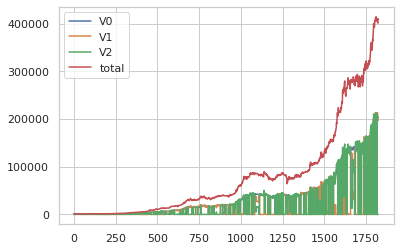

In [312]:
dfV=pd.DataFrame(np.array(model1.Vs),columns=['V0','V1','V2'])
dfV['total']=dfV.sum(axis=1)
# dfV.info()
# dfV.describe()

dfV.iloc[:,:].plot()

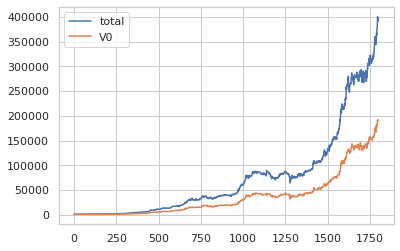

In [313]:
plt.plot(dfV.iloc[:1800,-1],label='total')
plt.plot(dfV.iloc[:1800,0],label='V0')

# plt.plot(dfV.iloc[:1800,1],label='V1')

# plt.plot(dfV.iloc[:1800,2],label='V2')


plt.legend()

In [314]:
dfW=pd.DataFrame(np.array(model1.Ws),columns=['w1','w2'])
dfW['status']=model1.status
# dfW.info()
# dfW.describe()
dfX=pd.DataFrame(np.array(model1.Xs),columns=['X0','X1','X2'])
# dfX.info()
# dfX.describe()

### 合并输出excel

In [316]:
pd.concat([dfW,dfX,dfV],axis=1).to_excel('./回测数据/r_0.5_0.1.xlsx',index=False)

## model2

In [208]:
model2=Model(f=0.1,alpha=0.9)

In [208]:
model2.main()

2
M 99.23507701227734
持有
权重： [0. 0.]
交易额： [-0.0, 0.0, 0.0]
portfolio [696.         196.14574117 100.20502895]
3
M 99.24084770403942
持有
权重： [0. 0.]
交易额： [-0.0, 0.0, 0.0]
portfolio [696.         196.54789673  99.86058031]
4
M 99.19887318397733
持有
权重： [0. 0.]
交易额： [-0.0, 0.0, 0.0]
portfolio [696.         195.8722754  100.11645644]
5
M 99.22823125575867
持有
权重： [0. 0.]
交易额： [-0.0, 0.0, 0.0]
portfolio [696.         196.37416553  99.90814703]
6
M 99.19427846162415
Mu0: 0.0
Mu: 0.0
权重： [0 0]
资产向量调整额： [0. 0. 0.]
commision 0.0
portfolio [696.         196.37416553  99.56861909]
7
M 99.26874497629602
Mu0: -0.0
Mu: -0.0
权重： [0 0]
资产向量调整额： [0. 0. 0.]
commision 0.0
portfolio [696.         196.37416553 100.31328424]
8
M 99.20508675278342
持有
权重： [0. 0.]
交易额： [-0.0, 0.0, 0.0]
portfolio [696.         195.96557548 100.08529204]
9
M 99.11339424958865
持有
权重： [0. 0.]
交易额： [-0.0, 0.0, 0.0]
portfolio [696.         195.29960589  99.83433661]
10
M 99.09904249616861
持有
权重： [0. 0.]
交易额： [-0.0, 0.0, 0.0]
portfolio 

IndexError: single positional indexer is out-of-bounds

<AxesSubplot:>

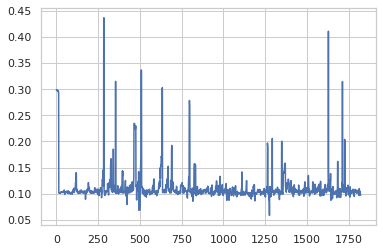

In [211]:
dfX=pd.DataFrame(np.array(model2.Xs),columns=['X0','X1','X2'])
dfV=pd.DataFrame(np.array(model2.Vs),columns=['V0','V1','V2'])
dfV['total']=dfV.sum(axis=1)
dfV['f_actual']=1-dfV['V0']/dfV['total']
dfV['f_actual'].plot()

In [195]:
pd.concat([dfX,dfV],axis=1)

,X0,X1,X2,V0,V1,V2,total,f_actual
0,-0.000000e+00,0.000000e+00,0.000000,6.960000e+02,1.965479e+02,99.860580,9.924085e+02,0.298676
1,-0.000000e+00,0.000000e+00,0.000000,6.960000e+02,1.958723e+02,100.116456,9.919887e+02,0.298379
2,-0.000000e+00,0.000000e+00,0.000000,6.960000e+02,1.963742e+02,99.908147,9.922823e+02,0.298587
3,-0.000000e+00,0.000000e+00,0.000000,6.960000e+02,1.963742e+02,99.568619,9.919428e+02,0.298347
4,0.000000e+00,0.000000e+00,0.000000,6.960000e+02,1.963742e+02,100.313284,9.926874e+02,0.298873
...,...,...,...,...,...,...,...,...
1818,0.000000e+00,0.000000e+00,0.000000,2.325496e+08,2.468041e+08,834.948197,4.793545e+08,0.514869
1819,-0.000000e+00,0.000000e+00,0.000000,2.325496e+08,2.441375e+08,849.598199,4.766880e+08,0.512156
1820,3.410936e+06,-5.792703e+06,-1699.185225,2.359605e+08,2.412792e+08,-754.943553,4.772390e+08,0.505572
1821,-0.000000e+00,0.000000e+00,0.000000,2.359605e+08,2.304734e+08,-743.157290,4.664332e+08,0.494117


## model3

In [218]:
model3=Model(f=0.3,alpha=0.1)
model3.main()

2
M 297.705231036832
持有
权重： [0. 0.]
交易额： [-0.0, 0.0, 0.0]
portfolio [696.         196.14574117 100.20502895]
3
M 297.7225431121182
持有
权重： [0. 0.]
交易额： [-0.0, 0.0, 0.0]
portfolio [696.         196.54789673  99.86058031]
4
M 297.59661955193195
持有
权重： [0. 0.]
交易额： [-0.0, 0.0, 0.0]
portfolio [696.         195.8722754  100.11645644]
5
M 297.684693767276
持有
权重： [0. 0.]
交易额： [-0.0, 0.0, 0.0]
portfolio [696.         196.37416553  99.90814703]
6
M 297.5828353848724
Mu0: 0.0
Mu: 0.0
权重： [0 0]
资产向量调整额： [0. 0. 0.]
commision 0.0
portfolio [696.         196.37416553  99.56861909]
7
M 297.80623492888805
Mu0: -0.0
Mu: -0.0
权重： [0 0]
资产向量调整额： [0. 0. 0.]
commision 0.0
portfolio [696.         196.37416553 100.31328424]
8
M 297.6152602583502
持有
权重： [0. 0.]
交易额： [-0.0, 0.0, 0.0]
portfolio [696.         195.96557548 100.08529204]
9
M 297.3401827487659
持有
权重： [0. 0.]
交易额： [-0.0, 0.0, 0.0]
portfolio [696.         195.29960589  99.83433661]
10
M 297.2971274885058
持有
权重： [0. 0.]
交易额： [-0.0, 0.0, 0.0]
portfolio 

IndexError: single positional indexer is out-of-bounds

<AxesSubplot:>

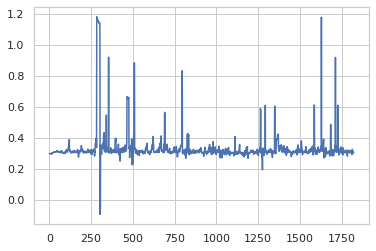

In [219]:
dfX=pd.DataFrame(np.array(model3.Xs),columns=['X0','X1','X2'])
dfV=pd.DataFrame(np.array(model3.Vs),columns=['V0','V1','V2'])
dfV['total']=dfV.sum(axis=1)
dfV['f_actual']=1-dfV['V0']/dfV['total']
dfV['f_actual'].plot()

In [220]:
pd.concat([dfX,dfV],axis=1).to_excel('./回测数据/model3_0.3_0.1.xlsx')

<AxesSubplot:>

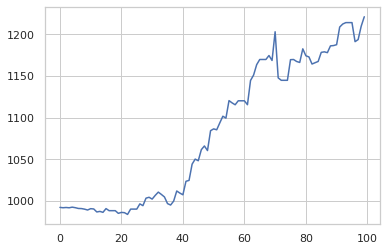

In [217]:
dfV['total'][:100].plot()

In [26]:
df.iloc[0,:][['Gold','Bitcoin']].fillna(0)

Gold         0.00
Bitcoin    621.65
Name: 0, dtype: float64

In [19]:
P=[df.iloc[1,:][]]

Date           2016-09-12 00:00:00
closed                       False
Gold                        1324.6
P1                             NaN
var1g                     0.000254
var2g                     0.000254
Bitcoin                     609.67
趋势                       -4.246667
P2                       -0.019271
var1b                     0.000254
var2b                     0.000248
cov1                      0.000007
cov2                      0.000007
cash                         500.0
G                            250.0
B                            250.0
Unnamed: 16                    min
Unnamed: 17               0.000172
volatie                        NaN
sign                          -1.0
调整率                            1.0
Name: 1, dtype: object

# vlookup

In [7]:
df=pd.read_excel('./回测数据/回测data.xlsx',sheet_name='gold')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265 entries, 0 to 1264
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 1255 non-null   datetime64[ns]
 1   Gold                 1255 non-null   float64       
 2   当日涨跌幅                1254 non-null   float64       
 3   过去5个交易日的方差（不包含当天）    1253 non-null   float64       
 4   未来5个交易日的方差（包含当天）     1253 non-null   float64       
 5   过去15个交易日的方差（不包含当天）   1249 non-null   float64       
 6   未来15个交易日的方差（包含当天）    1251 non-null   float64       
 7   过去60个交易日的方差（不包含当天）   1204 non-null   float64       
 8   未来60个交易日的方差（包含当天）    1206 non-null   float64       
 9   过去120个交易日的方差（不包含当天）  1145 non-null   float64       
 10  未来120个交易日的方差（包含当天）   1146 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 108.8 KB


In [8]:
df1=pd.DataFrame()
df1['Date']=pd.date_range(start='20160911',end='20210910',freq='D')
df1

,Date
0,2016-09-11
1,2016-09-12
2,2016-09-13
3,2016-09-14
4,2016-09-15
...,...
1821,2021-09-06
1822,2021-09-07
1823,2021-09-08
1824,2021-09-09


In [9]:
result = pd.merge(df1,df,how='left',on = 'Date')
result

,Date,Gold,当日涨跌幅,过去5个交易日的方差（不包含当天）,未来5个交易日的方差（包含当天）,过去15个交易日的方差（不包含当天）,未来15个交易日的方差（包含当天）,过去60个交易日的方差（不包含当天）,未来60个交易日的方差（包含当天）,过去120个交易日的方差（不包含当天）,未来120个交易日的方差（包含当天）
0,2016-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-09-12,1324.60,NaN,NaN,0.000079,NaN,0.000071,NaN,0.000254,NaN,0.000585
2,2016-09-13,1323.65,-0.019271,NaN,0.000009,NaN,0.000060,NaN,0.000248,NaN,0.000582
3,2016-09-14,1321.75,0.002050,NaN,0.000022,NaN,0.000060,NaN,0.000254,NaN,0.000738
4,2016-09-15,1310.80,-0.003437,NaN,0.000021,NaN,0.000059,NaN,0.000253,NaN,0.000738
...,...,...,...,...,...,...,...,...,...,...,...
1821,2021-09-06,1821.60,0.007680,0.000739,0.000629,0.000649,0.000629,0.000906,NaN,0.001040,NaN
1822,2021-09-07,1802.15,-0.010804,0.000734,0.000943,0.000493,NaN,0.000889,NaN,0.001037,NaN
1823,2021-09-08,1786.00,0.012312,0.000833,0.001160,0.000492,NaN,0.000894,NaN,0.001038,NaN
1824,2021-09-09,1788.25,-0.044786,0.000743,NaN,0.000473,NaN,0.000868,NaN,0.001054,NaN


In [13]:
result['closed']=result.isnull()['Gold']

In [14]:
result.to_csv('./temp.csv',index=False)

# 对比指标

In [318]:
import numpy as np
import matplotlib.pyplot as plt
 
def MaxDrawdown(return_list):
    '''最大回撤率'''
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))  # 结束位置
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])  # 开始位置
    return (return_list[j] - return_list[i]) / (return_list[j])
 
return_list=[12,12,21,15,27,16,21,22,25,20,16,17]
print(MaxDrawdown(return_list))

0.4074074074074074


In [319]:
result=pd.read_excel('./回测数据/r_0.5_0.1.xlsx',sheet_name='最大回撤')
for i in range(4):
    print(MaxDrawdown(result.iloc[:,i]))

0.28408415046600655
0.68951192598147
0.8337108231810031
0.833710823181003


# 敏感性分析

In [405]:
'''记录：
最终资产价值
交易次数
总收益率
手续费总额
f1平均值
f2平均值

'''
ls_state=[]
for i in range(0,21):
    i=i*0.15
    for j in range(0,21):
        j=j*0.15
        print(i,j)
        model_sen=Model(cost=[i/100,j/100])
        model_sen.main()
        Ws=np.array(model_sen.Ws)
        Xs=np.array(model_sen.Xs)
        Vs=np.array(model_sen.Vs)
        
        f1=np.mean(Vs[:,-2]/(Vs[:,0]+Vs[:,1]+Vs[:,2]))
        f2=np.mean(Vs[:,-1]/(Vs[:,0]+Vs[:,1]+Vs[:,2])) 
        
        total_V=Vs[-1,:].sum()#资产终值
        
        num_trades=(Xs!=0)[:,0].sum()#交易次数
        v_trades=np.absolute(Xs[1:]).sum(axis=1).sum()#交易额度
        com=np.sum(np.absolute(Xs).sum(axis=0)[1:]*np.array([i/100,j/100]))#交易费总额
        
        ls_state.append([i,j,f1,f2,total_V,num_trades,v_trades,com])

0.0 0.0
0.0 0.15
0.0 0.3
0.0 0.44999999999999996
0.0 0.6
0.0 0.75
0.0 0.8999999999999999
0.0 1.05
0.0 1.2
0.0 1.3499999999999999
0.0 1.5
0.0 1.65
0.0 1.7999999999999998
0.0 1.95
0.0 2.1
0.0 2.25
0.0 2.4
0.0 2.55
0.0 2.6999999999999997
0.0 2.85
0.0 3.0
0.15 0.0
0.15 0.15
0.15 0.3
0.15 0.44999999999999996
0.15 0.6
0.15 0.75
0.15 0.8999999999999999
0.15 1.05
0.15 1.2
0.15 1.3499999999999999
0.15 1.5
0.15 1.65
0.15 1.7999999999999998
0.15 1.95
0.15 2.1
0.15 2.25
0.15 2.4
0.15 2.55
0.15 2.6999999999999997
0.15 2.85
0.15 3.0
0.3 0.0
0.3 0.15
0.3 0.3
0.3 0.44999999999999996
0.3 0.6
0.3 0.75
0.3 0.8999999999999999
0.3 1.05
0.3 1.2
0.3 1.3499999999999999
0.3 1.5
0.3 1.65
0.3 1.7999999999999998
0.3 1.95
0.3 2.1
0.3 2.25
0.3 2.4
0.3 2.55
0.3 2.6999999999999997
0.3 2.85
0.3 3.0
0.44999999999999996 0.0
0.44999999999999996 0.15
0.44999999999999996 0.3
0.44999999999999996 0.44999999999999996
0.44999999999999996 0.6
0.44999999999999996 0.75
0.44999999999999996 0.8999999999999999
0.44999999999999996 1.

In [350]:
np.mean(Vs[:,-2]/(Vs[:,0]+Vs[:,1]+Vs[:,2]))

0.2055431300902323

In [355]:
np.absolute(Xs).sum(axis=0)[1:]*np.array([1/100,1/100])

array([4708.04879136, 4898.37153691])

## df_sen0.15

In [406]:
pd.DataFrame(np.array(ls_state),columns=['i','j','f1','f2','total_V','num_trades','V_trades','com']).to_excel('./回测数据/敏感性分析0.15.xlsx',index=False)

In [407]:
df_sen015=pd.DataFrame(np.array(ls_state),columns=['i','j','f1','f2','total_V','num_trades','V_trades','com'])


### com

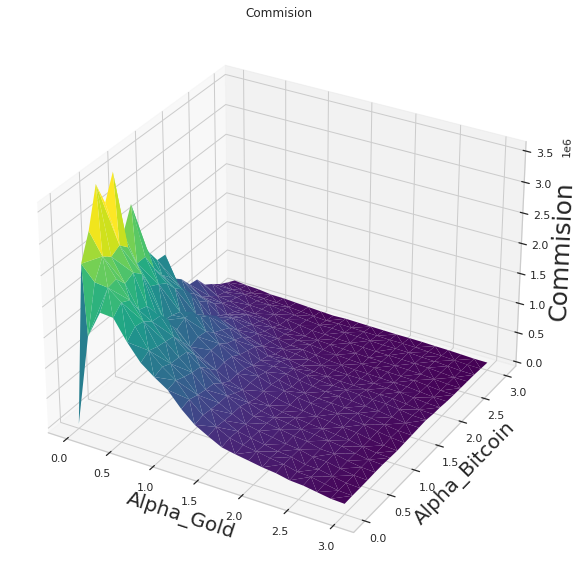

In [426]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


x=df_sen015['i']
y=df_sen015['j']

# z = np.cos(x ** 2 + y ** 2)
z=df_sen015.iloc[:,-1]

#绘制曲面图
fig = plt.figure(figsize=(16,10))
ax = plt.axes(projection='3d')
# 调用plot_surface()函数

ax.plot_trisurf (x, y, z,cmap='viridis', edgecolor='none')
ax.set_title('Commision')

ax.set_xlabel('Alpha_Gold',fontsize=20)
# ax.set_xlim3d((0,5))
# ax.set_ylim3d(0,5)
ax.set_ylabel('Alpha_Bitcoin',fontsize=20)
ax.set_zlabel('Commision',fontsize=25)

plt.show()

### V

In [412]:
sen015=df_sen015[df_sen015['i']<1.5][df_sen015['j']<1.5]

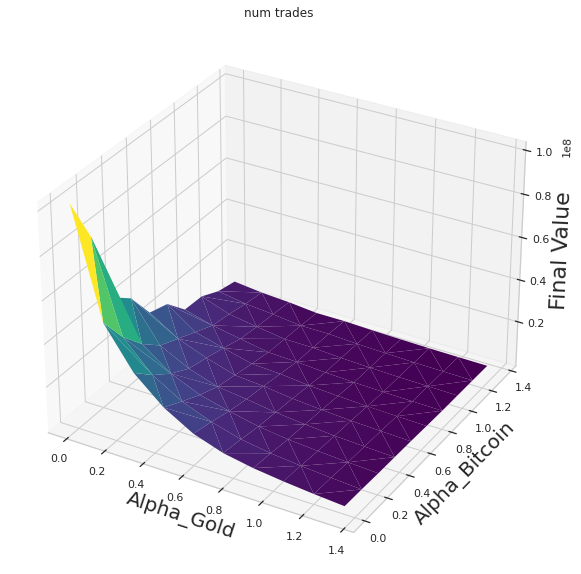

In [433]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


x=sen015['i']
y=sen015['j']

# z = np.cos(x ** 2 + y ** 2)
z=sen015.iloc[:,-4]

#绘制曲面图
fig = plt.figure(figsize=(16,10))
ax = plt.axes(projection='3d')
# 调用plot_surface()函数

ax.plot_trisurf (x, y, z,cmap='viridis', edgecolor='none')
ax.set_title('num trades')

ax.set_xlabel('Alpha_Gold',fontsize=20)
# ax.set_xlim3d((0,5))
# ax.set_ylim3d(0,5)
ax.set_ylabel('Alpha_Bitcoin',fontsize=20)
ax.set_zlabel('Final Value',fontsize=22)

plt.show()

## df_sen0.5

In [400]:
df_sen2=pd.DataFrame(np.array(ls_state),columns=['i','j','f1','f2','total_V','num_trades','V_trades','com'])
df_sen2

,i,j,f1,f2,total_V,num_trades,V_trades,com
0,0.0,0.0,0.211083,0.293622,1.018119e+08,1209.0,4.137548e+09,0.000000e+00
1,0.0,0.5,0.248234,0.257464,2.728644e+07,1048.0,1.189535e+09,2.924900e+06
2,0.0,1.0,0.270874,0.235670,9.180642e+06,957.0,4.280597e+08,2.100628e+06
3,0.0,1.5,0.294247,0.213579,4.556255e+06,877.0,2.207783e+08,1.625665e+06
4,0.0,2.0,0.322682,0.185553,1.901552e+06,819.0,1.000184e+08,9.811514e+05
...,...,...,...,...,...,...,...,...
116,5.0,3.0,0.149559,0.363985,1.737401e+04,370.0,6.963121e+05,2.531051e+04
117,5.0,3.5,0.159073,0.354844,1.508642e+04,330.0,5.972907e+05,2.313471e+04
118,5.0,4.0,0.170644,0.344375,1.111310e+04,292.0,5.087070e+05,2.103065e+04
119,5.0,4.5,0.198429,0.319372,1.101523e+04,264.0,4.443197e+05,1.943237e+04


In [401]:
pd.DataFrame(np.array(ls_state),columns=['i','j','f1','f2','total_V','num_trades','V_trades','com']).to_excel('./回测数据/敏感性分析0.5.xlsx',index=False)

### com

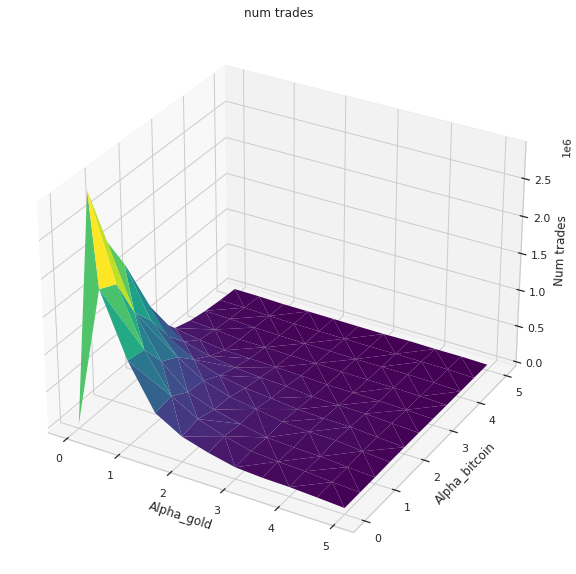

In [402]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


x=df_sen2['i']
y=df_sen2['j']

# z = np.cos(x ** 2 + y ** 2)
z=df_sen2.iloc[:,-1]

#绘制曲面图
fig = plt.figure(figsize=(16,10))
ax = plt.axes(projection='3d')
# 调用plot_surface()函数

ax.plot_trisurf (x, y, z,cmap='viridis', edgecolor='none')
ax.set_title('num trades')

ax.set_xlabel('Alpha_gold')
# ax.set_xlim3d((0,5))
# ax.set_ylim3d(0,5)
ax.set_ylabel('Alpha_bitcoin')
ax.set_zlabel('Num trades')

plt.show()

### V

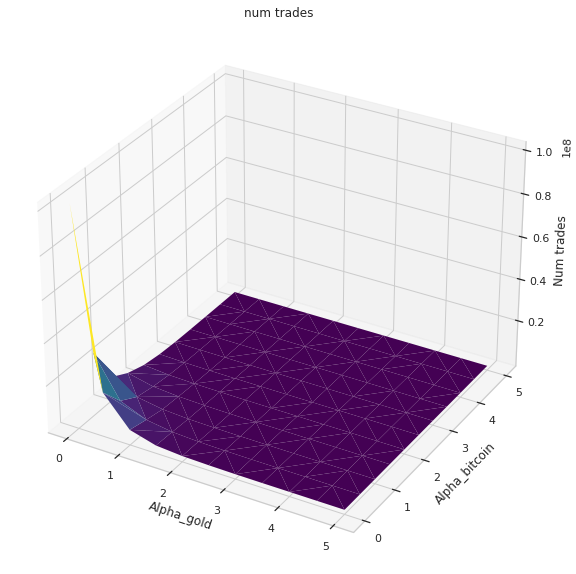

In [403]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


x=df_sen2['i']
y=df_sen2['j']

# z = np.cos(x ** 2 + y ** 2)
z=df_sen2.iloc[:,-4]

#绘制曲面图
fig = plt.figure(figsize=(16,10))
ax = plt.axes(projection='3d')
# 调用plot_surface()函数

ax.plot_trisurf (x, y, z,cmap='viridis', edgecolor='none')
ax.set_title('num trades')

ax.set_xlabel('Alpha_gold')
# ax.set_xlim3d((0,5))
# ax.set_ylim3d(0,5)
ax.set_ylabel('Alpha_bitcoin')
ax.set_zlabel('Num trades')

plt.show()

## df_sen1

In [371]:
df_sen=pd.DataFrame(np.array(ls_state),columns=['i','j','f1','f2','total_V','num_trades','V_trades','com'])
df_sen

,i,j,f1,f2,total_V,num_trades,V_trades,com
0,0.0,0.0,0.211083,0.293622,1.018119e+08,1209.0,4.137548e+09,0.000000e+00
1,0.0,1.0,0.270874,0.235670,9.180642e+06,957.0,4.280597e+08,2.100628e+06
2,0.0,2.0,0.322682,0.185553,1.901552e+06,819.0,1.000184e+08,9.811514e+05
3,0.0,3.0,0.349519,0.159577,2.306772e+05,741.0,1.412330e+07,2.060217e+05
4,0.0,4.0,0.384647,0.124766,6.401163e+04,686.0,4.517186e+06,8.720741e+04
...,...,...,...,...,...,...,...,...
116,10.0,6.0,0.135672,0.384153,1.577308e+04,139.0,1.571791e+05,9.988022e+03
117,10.0,7.0,0.138790,0.386007,1.334551e+04,112.0,1.305795e+05,8.912785e+03
118,10.0,8.0,0.179510,0.354925,7.004731e+03,87.0,7.987485e+04,5.911664e+03
119,10.0,9.0,0.201131,0.336410,8.520979e+03,74.0,7.580522e+04,5.844047e+03


In [367]:
pd.DataFrame(np.array(ls_state),columns=['i','j','f1','f2','total_V','num_trades','V_trades','com']).to_excel('./回测数据/敏感性分析.xlsx',index=False)

### num trades

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft YaHei


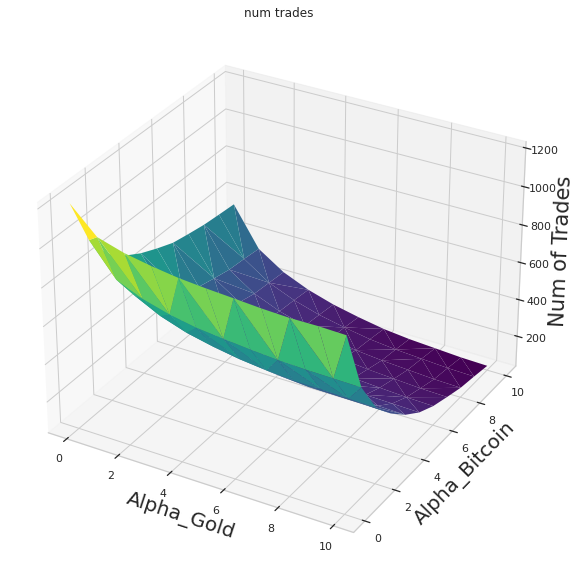

In [430]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt

x=df_sen['i']
y=df_sen['j']

# z = np.cos(x ** 2 + y ** 2)
z=df_sen.iloc[:,-3]

#绘制曲面图
fig = plt.figure(figsize=(16,10))
ax = plt.axes(projection='3d')
# 调用plot_surface()函数

ax.plot_trisurf (x, y, z,cmap='viridis', edgecolor='none')
ax.set_title('num trades')

ax.set_xlabel('Alpha_Gold',fontsize=20)
# ax.set_xlim3d((0,5))
# ax.set_ylim3d(0,5)
ax.set_ylabel('Alpha_Bitcoin',fontsize=20)
ax.set_zlabel('Num of Trades',fontsize=21)

plt.show()

### total V

In [394]:
sen1=df_sen[df_sen['i']<5][df_sen['j']<5]

sen2=df_sen[df_sen['i']<4][df_sen['j']<4]
sen1

,i,j,f1,f2,total_V,num_trades,V_trades,com
0,0.0,0.0,0.211083,0.293622,1.018119e+08,1209.0,4.137548e+09,0.000000e+00
1,0.0,1.0,0.270874,0.235670,9.180642e+06,957.0,4.280597e+08,2.100628e+06
2,0.0,2.0,0.322682,0.185553,1.901552e+06,819.0,1.000184e+08,9.811514e+05
3,0.0,3.0,0.349519,0.159577,2.306772e+05,741.0,1.412330e+07,2.060217e+05
4,0.0,4.0,0.384647,0.124766,6.401163e+04,686.0,4.517186e+06,8.720741e+04
11,1.0,0.0,0.128181,0.377741,5.119352e+06,1078.0,2.248859e+08,1.082228e+06
12,1.0,1.0,0.186836,0.320808,1.364822e+06,793.0,7.158775e+07,6.967661e+05
13,1.0,2.0,0.241419,0.268289,4.022870e+05,643.0,2.375686e+07,3.470737e+05
14,1.0,3.0,0.290920,0.220131,7.102359e+04,557.0,5.399231e+06,1.047247e+05
15,1.0,4.0,0.331793,0.179919,2.753234e+04,491.0,2.416871e+06,5.825697e+04


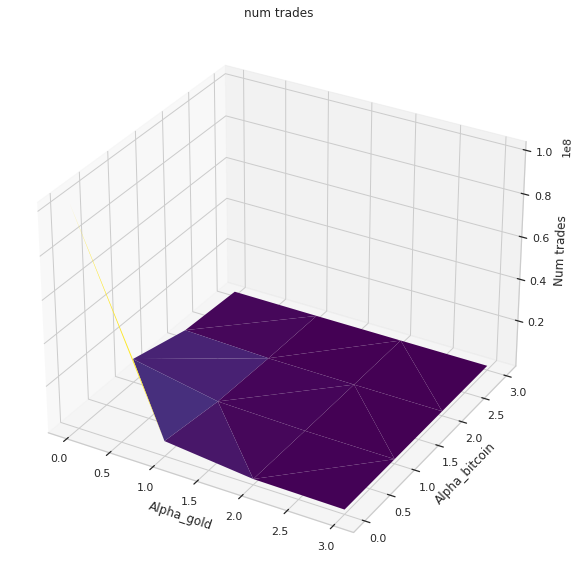

In [395]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


x=sen2['i']
y=sen2['j']

# z = np.cos(x ** 2 + y ** 2)
z=sen2.iloc[:,-4]

#绘制曲面图
fig = plt.figure(figsize=(16,10))
ax = plt.axes(projection='3d')
# 调用plot_surface()函数

ax.plot_trisurf (x, y, z,cmap='viridis', edgecolor='none')
ax.set_title('num trades')

ax.set_xlabel('Alpha_gold')
# ax.set_xlim3d((0,5))
# ax.set_ylim3d(0,5)
ax.set_ylabel('Alpha_bitcoin')
ax.set_zlabel('Num trades')

plt.show()

### com

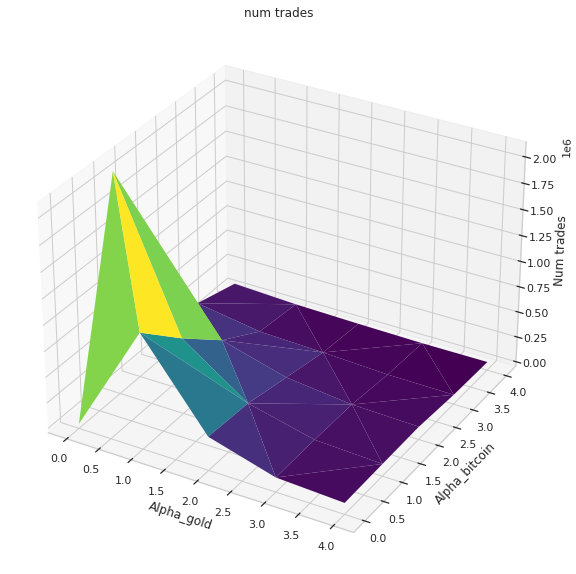

In [397]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt


x=sen1['i']
y=sen1['j']

# z = np.cos(x ** 2 + y ** 2)
z=sen1.iloc[:,-1]

#绘制曲面图
fig = plt.figure(figsize=(16,10))
ax = plt.axes(projection='3d')
# 调用plot_surface()函数

ax.plot_trisurf (x, y, z,cmap='viridis', edgecolor='none')
ax.set_title('num trades')

ax.set_xlabel('Alpha_gold')
# ax.set_xlim3d((0,5))
# ax.set_ylim3d(0,5)
ax.set_ylabel('Alpha_bitcoin')
ax.set_zlabel('Num trades')

plt.show()